# Naive estimator

We use the "native" estimator to:
- Setup the code we'll use
- Explore the effect of grid size and offset
- Give a baseline of what we might achieve

In [5]:
%matplotlib inline
from common1 import *

import pickle, bz2, datetime
import open_cp.data
import open_cp.geometry
import open_cp.naive
import open_cp.evaluation
import pandas as pd
import numpy as np
import open_cp.scripted.analysis as analysis

In [2]:
with bz2.open("geo.pic.bz") as f:
    geo = pickle.load(f)
with bz2.open("points1.pic.bz") as f:
    points = pickle.load(f)
points.time_range, points.number_data_points

((numpy.datetime64('2007-01-01T02:00:00.000'),
  numpy.datetime64('2007-12-31T21:00:00.000')),
 3545)

### Set the grid size

In [3]:
grid = open_cp.data.Grid(xsize=150, ysize=150, xoffset=0, yoffset=0)
grid = open_cp.geometry.mask_grid_by_intersection(geo, grid)

### Make a prediction

In [4]:
predictor = open_cp.naive.CountingGridKernel(grid.xsize, region=grid.region())

In [5]:
predict_time = datetime.datetime(2007,10,1)
score_end_time = predict_time + datetime.timedelta(days=1)
predictor.data = points[points.timestamps <= predict_time]
prediction = predictor.predict()

In [6]:
prediction.mask_with(grid)

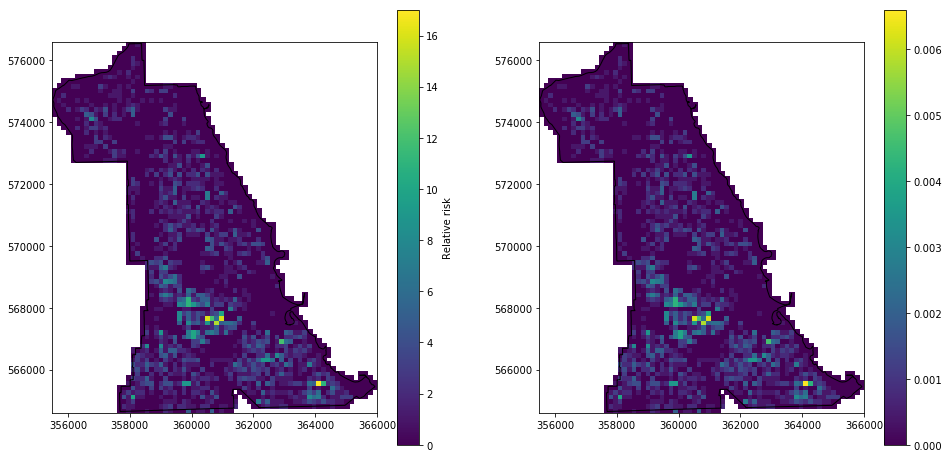

In [7]:
fig = plot_grid_prediction_two_up(geo, prediction)

### Typical "hotspot"

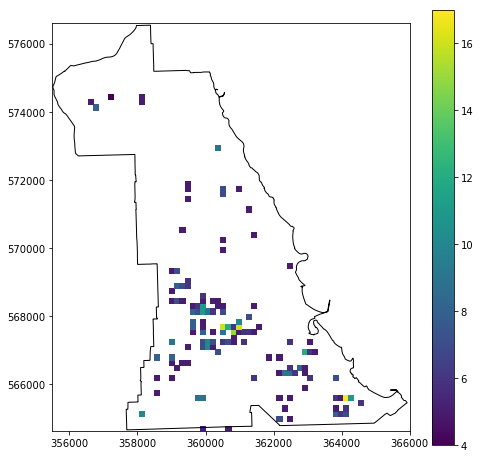

In [8]:
grid_pred = open_cp.evaluation.top_slice_prediction(prediction, 5/100)
ax, cb = plot_grid_prediction(geo, grid_pred)

### Score the prediction

In [9]:
coverages = list(range(1, 51))

In [10]:
mask = (points.timestamps >= predict_time) & (points.timestamps <= score_end_time)
eval_pts = points[mask]
hitrates = open_cp.evaluation.hit_rates(prediction, eval_pts, coverages)

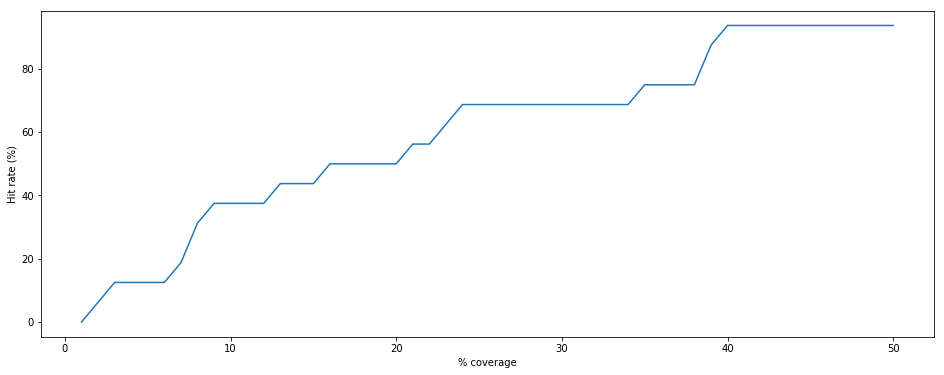

In [11]:
fig, ax = plt.subplots(figsize=(16,6))

ax.plot(coverages, [100*hitrates[x] for x in coverages])
ax.set(xlabel="% coverage", ylabel="Hit rate (%)")
None

# Reload the analysis

Run the script `analysis_naive.py` first!

In [13]:
betas = analysis.hit_counts_to_beta("naive_counts.csv")

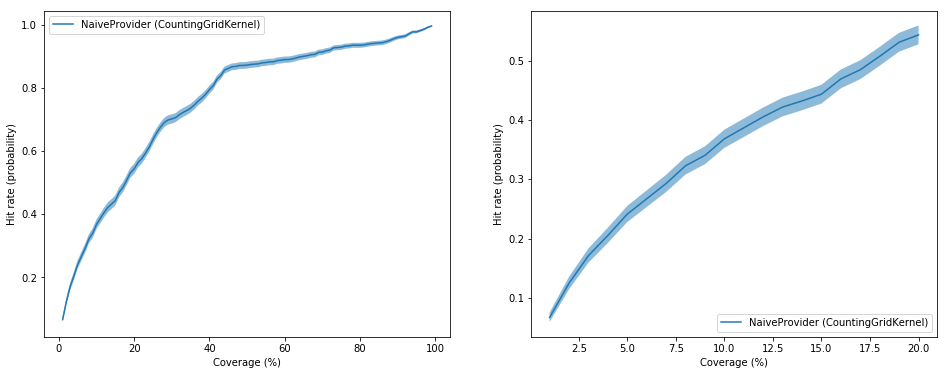

In [14]:
fig, axes = plt.subplots(ncols=2, figsize=(16,6))
analysis.plot_betas(betas, axes[0])
analysis.plot_betas(betas, axes[1], coverages=range(1,21))
axes[1].legend(loc="lower right")

# Run in a notebook

In [15]:
import open_cp.scripted
import io

In [25]:
all_betas = {}

for _ in range(50):
    f = io.StringIO()
    xo = np.random.randint(0, 150)
    yo = np.random.randint(0, 150)
    grid = open_cp.data.Grid(xsize=150, ysize=150, xoffset=xo, yoffset=yo)
    with open_cp.scripted.Data(lambda : points, lambda : geo,
            start=datetime.datetime(2007,1,1), grid=grid) as state:

        time_range = open_cp.scripted.TimeRange(datetime.datetime(2007,10,1),
                datetime.datetime(2008,1,1), datetime.timedelta(days=1))
        state.add_prediction(open_cp.scripted.NaiveProvider, time_range)

        state.score(open_cp.scripted.HitCountEvaluator)
        state.process(open_cp.scripted.HitCountSave(f))
    all_betas[(xo, yo)] = analysis.hit_counts_to_beta(io.StringIO(f.getvalue()))

In [34]:
pname = 'NaiveProvider (CountingGridKernel)'
keys = list(all_betas)
coverages = list(range(1, 21))
medians = {key : { c : all_betas[key][pname][c].median() for c in coverages}
           for key in keys}

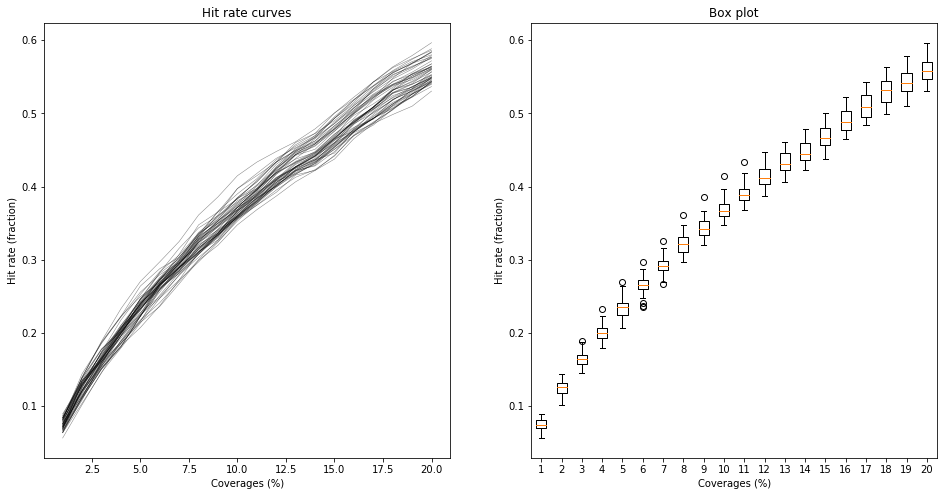

In [44]:
fig, axes = plt.subplots(ncols=2, figsize=(16,8))

ax = axes[0]
for key in keys:
    y = [medians[key][c] for c in coverages]
    ax.plot(coverages, y, linewidth=0.5, color="black", alpha=0.5)
ax.set_title("Hit rate curves")
    
ax = axes[1]
data = []
for c in coverages:
    data.append([medians[key][c] for key in keys])
ax.boxplot(data)
ax.set_title("Box plot")

for ax in axes:
    ax.set(xlabel="Coverages (%)", ylabel="Hit rate (fraction)")

## For the redistributed points

And the same again...

In [2]:
with bz2.open("geo.pic.bz") as f:
    geo = pickle.load(f)
with bz2.open("points2.pic.bz") as f:
    points = pickle.load(f)
points.time_range, points.number_data_points

((numpy.datetime64('2007-01-01T02:00:00.000'),
  numpy.datetime64('2007-12-31T21:00:00.000')),
 3556)

In [3]:
import open_cp.scripted
import io

In [6]:
all_betas = {}

for _ in range(50):
    f = io.StringIO()
    xo = np.random.randint(0, 150)
    yo = np.random.randint(0, 150)
    grid = open_cp.data.Grid(xsize=150, ysize=150, xoffset=xo, yoffset=yo)
    with open_cp.scripted.Data(lambda : points, lambda : geo,
            start=datetime.datetime(2007,1,1), grid=grid) as state:

        time_range = open_cp.scripted.TimeRange(datetime.datetime(2007,10,1),
                datetime.datetime(2008,1,1), datetime.timedelta(days=1))
        state.add_prediction(open_cp.scripted.NaiveProvider, time_range)

        state.score(open_cp.scripted.HitCountEvaluator)
        state.process(open_cp.scripted.HitCountSave(f))
    all_betas[(xo, yo)] = analysis.hit_counts_to_beta(io.StringIO(f.getvalue()))

In [7]:
pname = 'NaiveProvider (CountingGridKernel)'
keys = list(all_betas)
coverages = list(range(1, 21))
medians = {key : { c : all_betas[key][pname][c].median() for c in coverages}
           for key in keys}

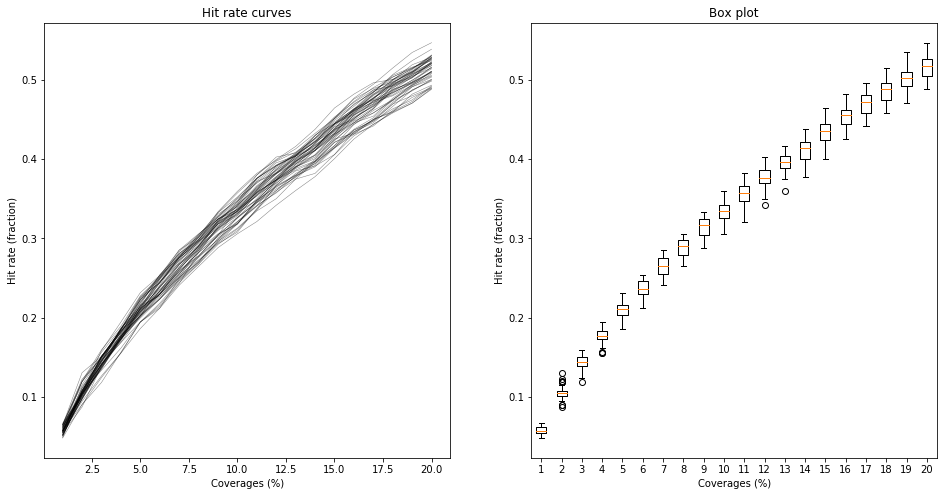

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(16,8))

ax = axes[0]
for key in keys:
    y = [medians[key][c] for c in coverages]
    ax.plot(coverages, y, linewidth=0.5, color="black", alpha=0.5)
ax.set_title("Hit rate curves")
    
ax = axes[1]
data = []
for c in coverages:
    data.append([medians[key][c] for key in keys])
ax.boxplot(data)
ax.set_title("Box plot")

for ax in axes:
    ax.set(xlabel="Coverages (%)", ylabel="Hit rate (fraction)")